# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster
import joblib

In [ ]:
cluster_general = SLURMCluster(
        cores=8,
        memory='20GB',
        walltime='12:00:00',
        interface=None,
        scheduler_options={'interface': 'eth1'},
        job_extra_directives=['--output=/dev/null',
                             '--error=/dev/null']
    )
cluster_general.scale(jobs=10)
display(cluster_general)
cluster_general.wait_for_workers(10)

In [ ]:
# packageroot = Path('../../').resolve()
packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

core.set_temp_directory('/scr1/users/dongjp')

In [4]:
# cluster_spike = SLURMCluster(
#         cores=1,
#         memory='10GB',
#         processes=1,
#         walltime='12:00:00',
#         interface=None,
#         scheduler_options={'interface': 'eth1'},
#         job_extra_directives=['--output=/dev/null',
#                              '--error=/dev/null']
#     )
# cluster_spike.scale(10)
# display(cluster_spike)
# cluster_spike.wait_for_workers(10)

In [5]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()

In [ ]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25']
# animal_ids = ['A5']
animal_ids = ['A10']
# animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec() # paralleization breaks if not enough memory

    # with Client(cluster_window) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running war")
    #     war = ao.compute_windowed_analysis(['all'], exclude=['nspike', 'wavetemp'], multiprocess_mode='dask')
    #     war.to_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())

    # with Client(cluster_spike) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')

    with Client(LocalCluster()) as client:
        client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running sar")
        sar = ao.compute_spike_analysis(multiprocess_mode='dask')

In [12]:
logger.setLevel(logging.DEBUG)

In [13]:
# for e in sar:
#     e.convert_to_mne(chunk_len=1440)
#     e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve())

In [ ]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

In [14]:
logger.setLevel(logging.WARNING)


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


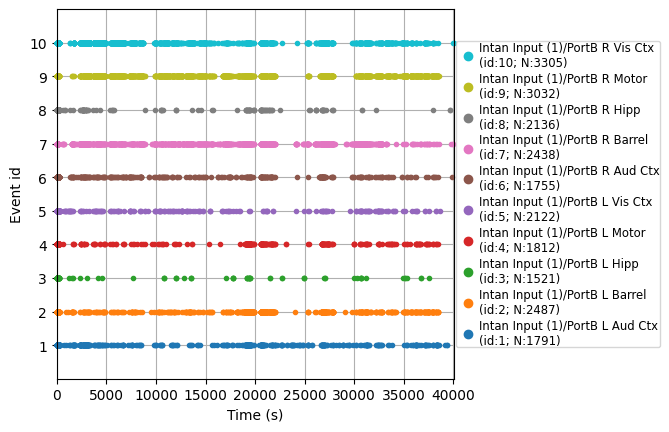

In [15]:
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)

In [19]:
def random_subsample_epochs(epochs: mne.Epochs, max_epochs=1000):
    if len(epochs) > max_epochs:
        # Get random indices for subsampling
        indices = np.random.choice(len(epochs), size=max_epochs, replace=False)
        epochs = epochs[indices]
    return epochs

In [21]:
# quick hack to look at peri-spike EEG

def analyze_peri_spike_tfr(mne_obj: mne.io.Raw, tmin=-10, tmax=5, tcrop=(-3, 3), baseline=(None, -5), l_freq=1, h_freq=50):
    """
    Analyze time-frequency representation around spikes from an MNE object.
    
    Parameters:
    -----------
    mne_obj : mne.io.Raw
        The MNE object containing the data and spike annotations
    tmin : float
        Start time relative to spike (in seconds)
    tmax : float
        End time relative to spike (in seconds)
    tcrop : tuple
        Time range to crop the data (in seconds)
    baseline : tuple
        Time range to compute baseline (in seconds)
    l_freq : float
        Lower frequency bound for filtering
    h_freq : float
        Upper frequency bound for filtering
    """
    raw = mne_obj.copy()
    
    # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
    # raw.filter(l_freq=l_freq, h_freq=h_freq)

    events, event_dict = mne.events_from_annotations(raw=raw)
    logging.debug(f"Events: {events}")
    logging.debug(f"Event dict: {event_dict}")

    # Process each spike type separately
    for channel_name in event_dict.keys():
        logging.debug(f"Processing channel: {channel_name}")
        
        # Create spike-centered epochs
        epochs = mne.Epochs(
            raw,
            tmin=tmin,
            tmax=tmax,
            baseline=baseline,
            event_repeated='drop',
            # preload=True,
            event_id=channel_name,
        )
        epochs.drop_bad()
        epochs = random_subsample_epochs(epochs).load_data()
        epochs.crop(tmin=tcrop[0], tmax=tcrop[1])
        # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
        epochs.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Plot the epochs
        epochs.plot_image([channel_name])

        
        logging.info(f"Computing TFR: {channel_name}")
        with joblib.parallel_config('dask', scheduler_host=cluster_general.scheduler_address):
            # epochs.tfr_stockwell(l_freq=l_freq, h_freq=h_freq)
            # tfr_spike = epochs.compute_tfr(freqs=(l_freq, h_freq), method='stockwell', average=True)
            tfr_spike = epochs.compute_tfr(freqs=np.arange(l_freq, h_freq, 1), n_cycles=np.arange(l_freq, h_freq, 1) * 2, method='multitaper', use_fft=True, average=True)
            # TODO take log?
            # TODO implement morlet
        
        tfr_spike.plot()

        break


In [22]:
def plot_tfr_hilbert(epochs: mne.Epochs, freqs: list[float], bandwidth: float):
    data = np.empty((len(epochs), len(epochs.ch_names), freqs.size, epochs.times.size), dtype=complex)
    logging.info(f"data shape: {data.shape}")
    for idx, freq in enumerate(freqs):
        data[:, :, idx] = epochs.get_data()
        
    # TODO implement hilbert transform on narrowband filter

    # power = mne.time_frequency.EpochsTFRArray(epochs.info, data, epochs.times, freqs, method="hilbert")
    # power.average().plot(
    #     [0],
    #     baseline=(0.0, 0.1),
    #     mode="mean",
    #     vlim=(0, 0.1),
    #     axes=ax,
    #     show=False,

        

# fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, layout="constrained")
# bandwidths = [1.0, 2.0, 4.0]
# for bandwidth, ax in zip(bandwidths, axs):
#     data = np.zeros(
#         (len(epochs), len(ch_names), freqs.size, epochs.times.size), dtype=complex
#     )
#     for idx, freq in enumerate(freqs):
#         # Filter raw data and re-epoch to avoid the filter being longer than
#         # the epoch data for low frequencies and short epochs, such as here.
#         raw_filter = raw.copy()
#         # NOTE: The bandwidths of the filters are changed from their defaults
#         # to exaggerate differences. With the default transition bandwidths,
#         # these are all very similar because the filters are almost the same.
#         # In practice, using the default is usually a wise choice.
#         raw_filter.filter(
#             l_freq=freq - bandwidth / 2,
#             h_freq=freq + bandwidth / 2,
#             # no negative values for large bandwidth and low freq
#             l_trans_bandwidth=min([4 * bandwidth, freq - bandwidth]),
#             h_trans_bandwidth=4 * bandwidth,
#         )
#         raw_filter.apply_hilbert()
#         epochs_hilb = Epochs(
#             raw_filter, events, tmin=0, tmax=n_times / sfreq, baseline=(0, 0.1)
#         )
#         data[:, :, idx] = epochs_hilb.get_data()
#     power = EpochsTFRArray(epochs.info, data, epochs.times, freqs, method="hilbert")
#     power.average().plot(
#         [0],
#         baseline=(0.0, 0.1),
#         mode="mean",
#         vlim=(0, 0.1),
#         axes=ax,
#         show=False,
#         colorbar=False,
#     )
#     n_cycles = "scaled by freqs" if not isinstance(n_cycles, int) else n_cycles
#     ax.set_title(
#         "Sim: Using narrow bandpass filter Hilbert,\n"
#         f"bandwidth = {bandwidth}, "
#         f"transition bandwidth = {4 * bandwidth}"
#     )

In [23]:
logger.setLevel(logging.DEBUG)

Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]
2025-03-20 15:14:07,059 - DEBUG - Events: [[     121        0        5]
 [     125        0        4]
 [     139        0        5]
 ...
 [39959945        0        7]
 [39975664        0       10]
 [40050738        0       10]]
2025-03-20 15:14:07,060 - DEBUG - Event dict: {np.str_('Intan Input (1)/PortB L Aud Ctx'): 1, np.str_('Intan Input (1)/PortB L Barrel'): 2, np.str_('Intan Input (1)/PortB L Hipp'): 3, np.str_('Intan Input (1)/PortB L Motor'): 4, np.str_('Intan Input (1)/PortB L Vis Ctx'): 5, np.str_('Intan Input (1)/PortB R Aud

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    3.2s
[Parallel(n_job

Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
2025-03-20 15:15:14,549 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f7417ecca00>
2025-03-20 15:15:14,668 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-03-20 15:15:14,670 - DEBUG - findfont: score(FontEntry(fname='/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-03-20 15:15:14,670 - DEBUG - findfont: score(FontEntry(fname='/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-03-20 15:15:14,671 - DEBUG - findfont: score(FontEntry

/tmp/ipykernel_583369/2556557925.py:54: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image([channel_name])


2025-03-20 15:15:14,737 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/liberation-sans/LiberationSans-Regular.ttf', name='Liberation Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-03-20 15:15:14,738 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/google-droid-sans-fonts/DroidSansEthiopic-Regular.ttf', name='Droid Sans Ethiopic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-03-20 15:15:14,738 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/google-noto/NotoSansGurmukhi-SemiCondensedBold.ttf', name='Noto Sans Gurmukhi', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
2025-03-20 15:15:14,739 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/google-noto-cjk/NotoSansCJK-Regular.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


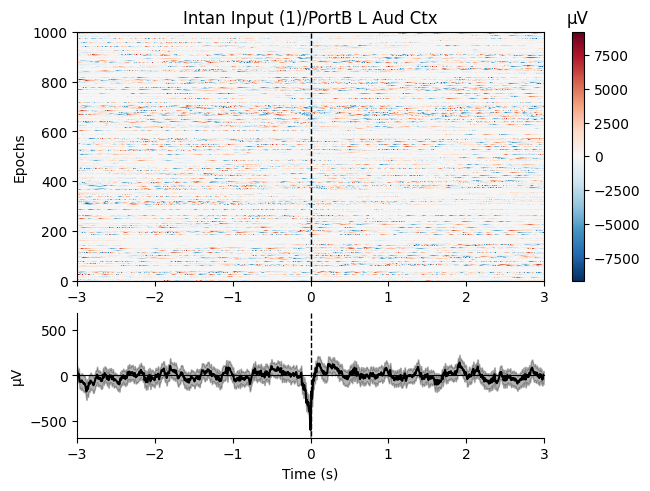

2025-03-20 15:15:17,145 - INFO - Computing TFR: Intan Input (1)/PortB L Aud Ctx
2025-03-20 15:15:17,159 - DEBUG - Using selector: EpollSelector


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   33.3s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   36.2s remaining:   24.1s


No baseline correction applied


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   45.2s finished


2025-03-20 15:16:05,488 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73fc56e110>
2025-03-20 15:16:05,543 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73fc5b4c70>
2025-03-20 15:16:05,612 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73fc5d78e0>
2025-03-20 15:16:05,659 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73fc426200>
2025-03-20 15:16:05,705 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73fc470f10>
2025-03-20 15:16:05,771 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73fc497b50>
2025-03-20 15:16:05,838 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73fc4e2410>
2025-03-20 15:16:05,916 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73facbd810>
2025-03-20 15:16:05,991 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73face3d90>
2025-03-20 15:16:06,054 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f73fad3a5f0>


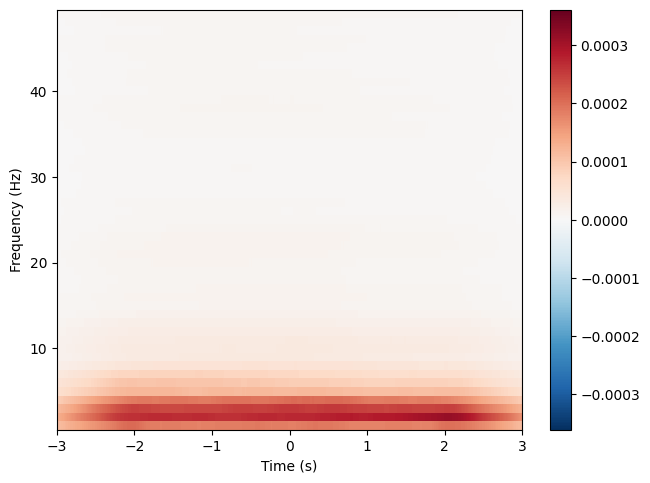

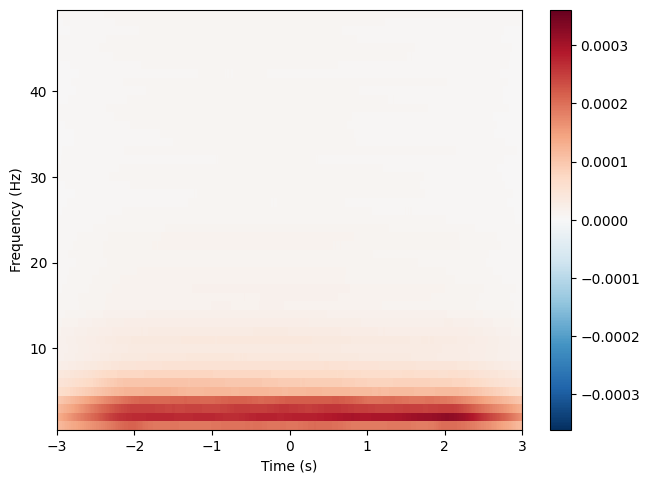

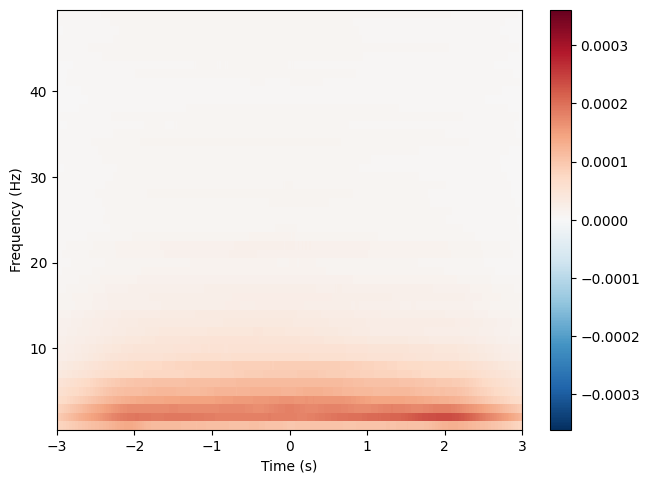

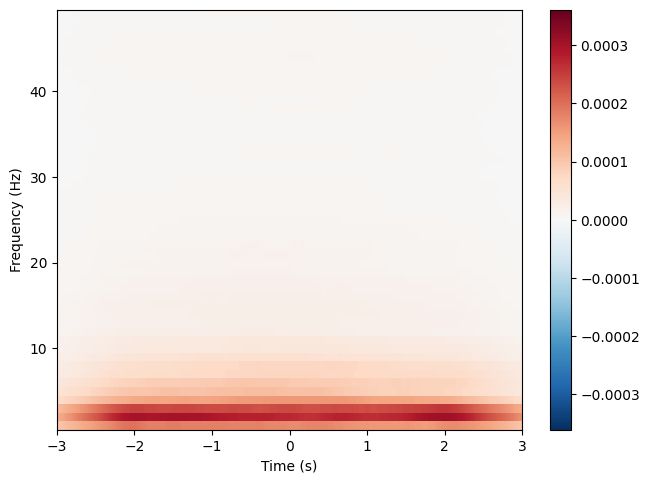

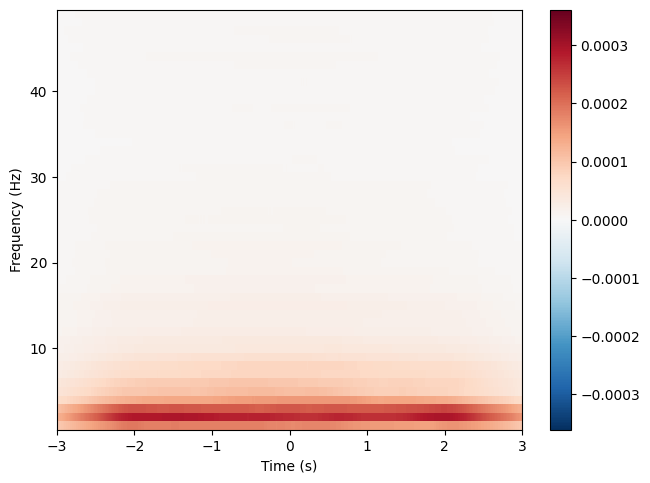

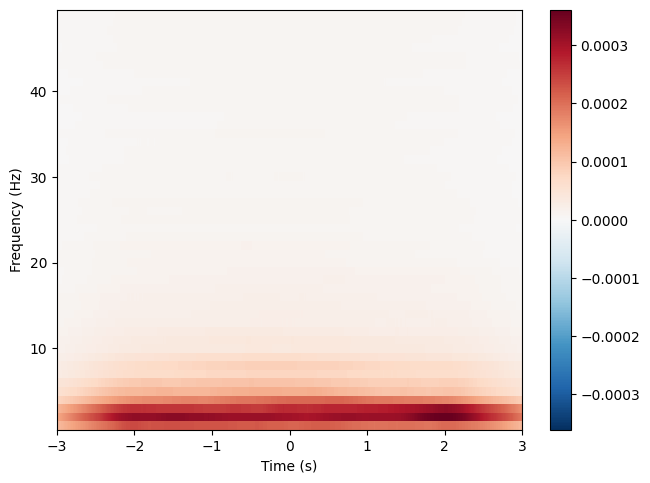

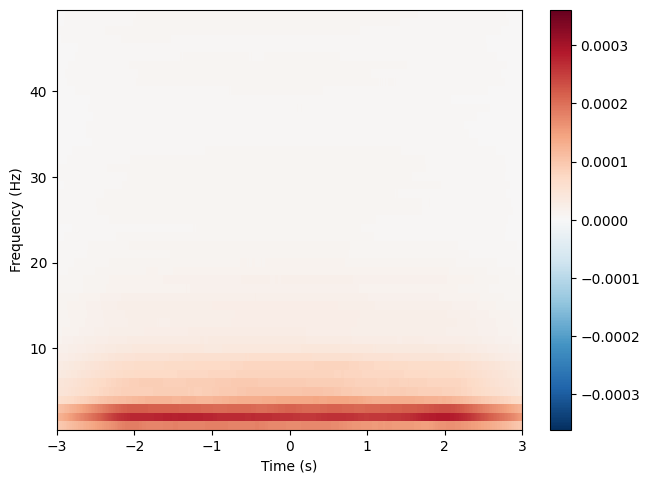

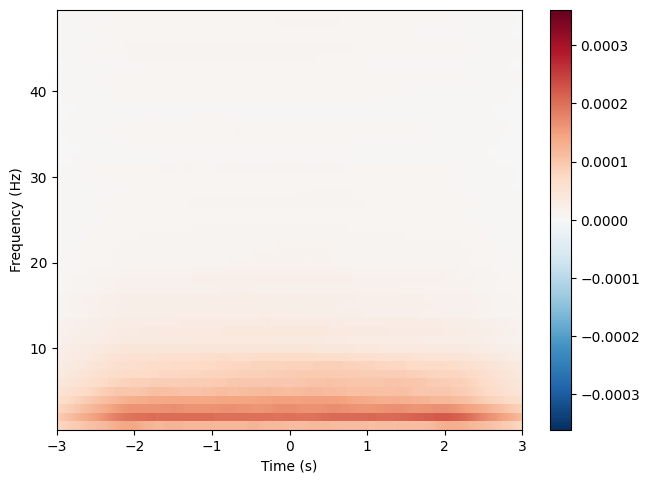

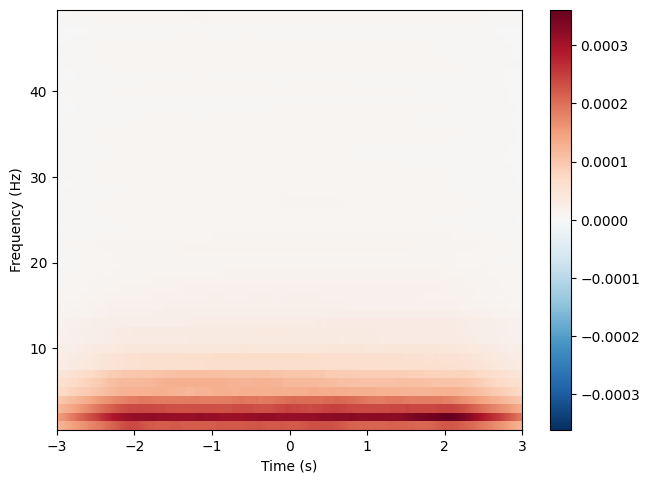

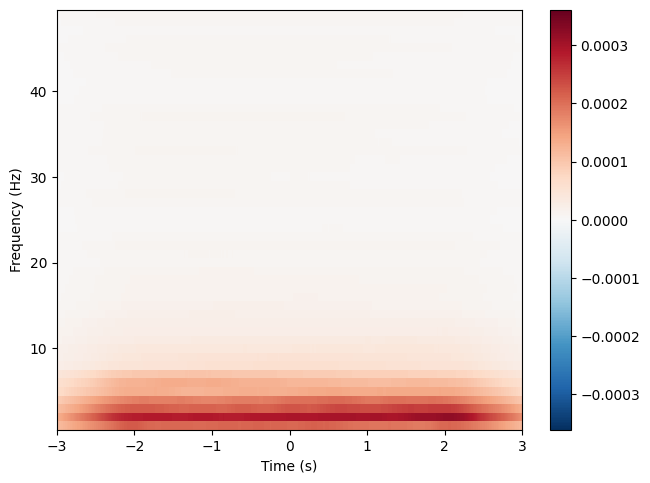

In [24]:
# display(mne_obj)
analyze_peri_spike_tfr(mne_obj)